In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
import joblib
from sklearn.metrics import mean_squared_error
from format_data import create_dataframe
from preprocess import preprocess_supervised, OutputColumn

In [2]:
def split_target_from_dataset(Db, target='output'):  # Remove target col
    y = Db[target]
    X = Db.drop(columns=[target])
    return X, y

In [3]:
def save_model(pipeline, model_filepath):
    joblib.dump(pipeline, model_filepath)

In [4]:
data_file_path="welddb/welddb.data"
model_file_path = 'models/xgboost_model.pkl'
target = OutputColumn.yield_strength

In [5]:
print("Loading the dataset")
Db = create_dataframe(data_file_path)
print("Preprocessing")
Db = preprocess_supervised(Db, target)

print("Split target from the dataset")
X, y = split_target_from_dataset(Db)

Loading the dataset
Preprocessing


c:\Users\ADMIN\Desktop\3A\INFONUM + Mention IA\Apprentissage Automatique\apprAuto-projet\format_data.py:67: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Db[NUMERICAL_COL] = Db[NUMERICAL_COL].applymap(convert_less_than)


We retain only the rows with output values Yield strength / MPa, that is 47.215496% of the dataset


c:\Users\ADMIN\Desktop\3A\INFONUM + Mention IA\Apprentissage Automatique\apprAuto-projet\preprocess.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Db[num_columns] = iterative_imputer.fit_transform(Db[num_columns])


Split target from the dataset


c:\Users\ADMIN\Desktop\3A\INFONUM + Mention IA\Apprentissage Automatique\apprAuto-projet\preprocess.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Db[cat_columns] = impute_categorical(Db, cat_columns)
c:\Users\ADMIN\Desktop\3A\INFONUM + Mention IA\Apprentissage Automatique\apprAuto-projet\preprocess.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Db[cat_columns] = Db[cat_columns].apply(lambda x: x >= 0.5)
c:\Users\ADMIN\Desktop\3A\INFONUM + Mention IA\Apprentissage Automatique\apprAuto-projet\p

In [6]:
print("Train/Test split")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21)

Train/Test split


In [7]:
print("Creating Pipelines")
pipeline_xgboost = Pipeline([('model', XGBRegressor(random_state=17))])
pipeline_catboost = Pipeline([('model', CatBoostRegressor(verbose=0, random_state=17))])
pipeline_lgbm = Pipeline([('model', LGBMRegressor(verbose=0, random_state=17))])

Creating Pipelines


In [8]:
def evaluate_pipeline(pipeline, param_grid):

    print("Performing Grid Search with Cross-Validation")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best hyperparameters: ", grid_search.best_params_)
    print("Best cross-validation MSE: ", abs(grid_search.best_score_))

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    test_mse = mean_squared_error(y_test, y_pred)
    print("Test set MSE with best model: ", test_mse)
    

    # Plot the predicted values against the actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')  # Scatter plot of predicted vs actual
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')  # Line for perfect predictions
    
    # Set equal scaling
    plt.xlim(min(y_test), max(y_test))
    plt.ylim(min(y_test), max(y_test))
    plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio

    plt.title('Predicted vs Actual values of y_test')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.grid()
    plt.show()

Performing Grid Search with Cross-Validation
Best hyperparameters:  {'model__eta': 0.05, 'model__max_depth': 5, 'model__n_estimators': 700}
Best cross-validation MSE:  3161.106778684046
Test set MSE with best model:  3099.4171752254656


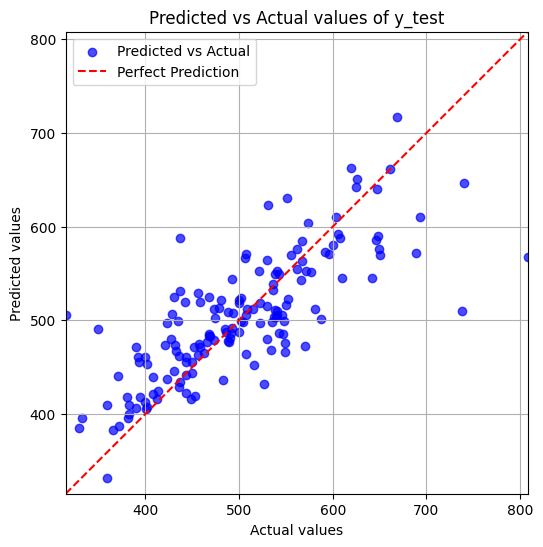

In [13]:
# XGBoost

param_grid_xgboost = {
        'model__n_estimators': [300, 400, 500, 600, 700, 800, 900],
        'model__max_depth': [5, 6, 7, 8, 9, 10],
        'model__eta': [0.01, 0.05, 0.1]
    }

evaluate_pipeline(pipeline_xgboost, param_grid_xgboost)

Performing Grid Search with Cross-Validation
Best hyperparameters:  {'model__iterations': 300, 'model__learning_rate': 0.1}
Best cross-validation MSE:  3095.2872568815606
Test set MSE with best model:  3229.7280634330737


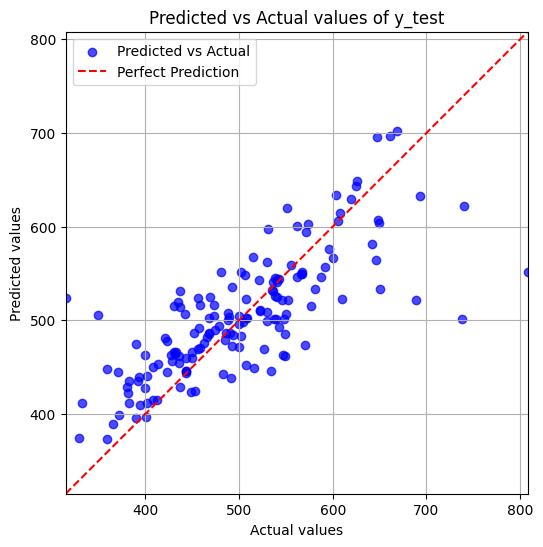

In [10]:
# CATBoost

param_grid_catboost = {
    'model__iterations': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1]
}

evaluate_pipeline(pipeline_catboost, param_grid_catboost)

Performing Grid Search with Cross-Validation
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

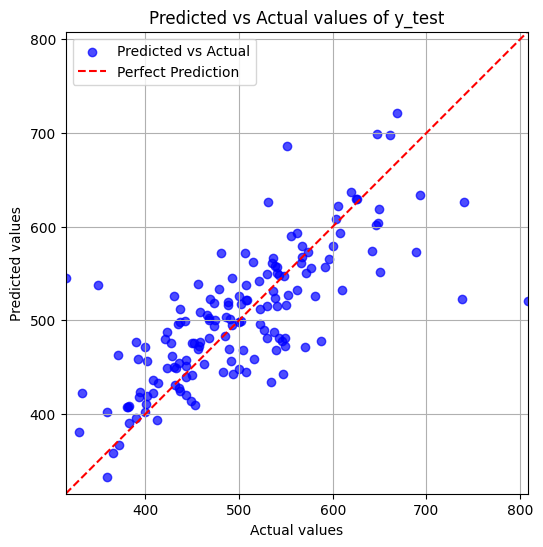

In [11]:
# LightGBM

param_grid_lgbm = {
    'model__n_estimators': [300, 400, 500, 600],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [15, 30, 50, 100]
}

evaluate_pipeline(pipeline_lgbm, param_grid_lgbm)

In [12]:
print("Evaluation on test set")
# y_pred = pipeline.predict(X_test)
print("Score: ", pipeline.score(X_test, y_test))

Evaluation on test set


NameError: name 'pipeline' is not defined

In [ ]:
print("Saving the model")
save_model(pipeline, model_file_path)